In [1]:
%%capture
# move to src folder so we can import code
%cd ../src

In [2]:
import config
from common.kaggle import download_competition_data
from eda.plot import plot_count, pair_plot, plot_correlation_heatmap


In [3]:
download_competition_data(config.COMPETITION, config.INPUTS)


In this competition we will be using data generated by a deep learning model dfed on the [Stroke Prediction Dataset.](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). We can expect the relationships between variables to be similar as in the original dataset, but not exactly the same.

We will be predicting whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. The independent variables at our disposal are:

1. **id**: unique identifier
1. **gender**: "Male", "Female" or "Other"
1. **age**: age of the patient
1. **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
1. **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
1. **ever_married**: "No" or "Yes"
1. **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
1. **Residence_type**: "Rural" or "Urban"
1. **avg_glucose_level**: average glucose level in blood
1. **bmi**: body mass index
1. **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown"\*
1. **stroke**: 1 if the patient had a stroke or 0 if not

Note: "Unknown" in smoking_status means that the information is unavailable for this patient

The evaluation metric is going to be AUC.


# Let's take a look at the data


In [4]:
from pathlib import Path
import pandas as pd


In [5]:
df = pd.read_csv(config.TRAIN_DATA)
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [7]:
df.nunique()


id                   15304
gender                   3
age                    106
hypertension             2
heart_disease            2
ever_married             2
work_type                5
Residence_type           2
avg_glucose_level     3740
bmi                    407
smoking_status           4
stroke                   2
dtype: int64

In [8]:
len(df[df.duplicated()])


0

`age`, `avg_glucose_level` and `bmi` are numerical. The rest are categorical. id can be ignored, as its value is unique


In [9]:
ord_features = ["age", "avg_glucose_level", "bmi"]


In [10]:
features = [f for f in df.columns if f not in (config.TARGET, "id")]
cat_features = [f for f in features if f not in ord_features]


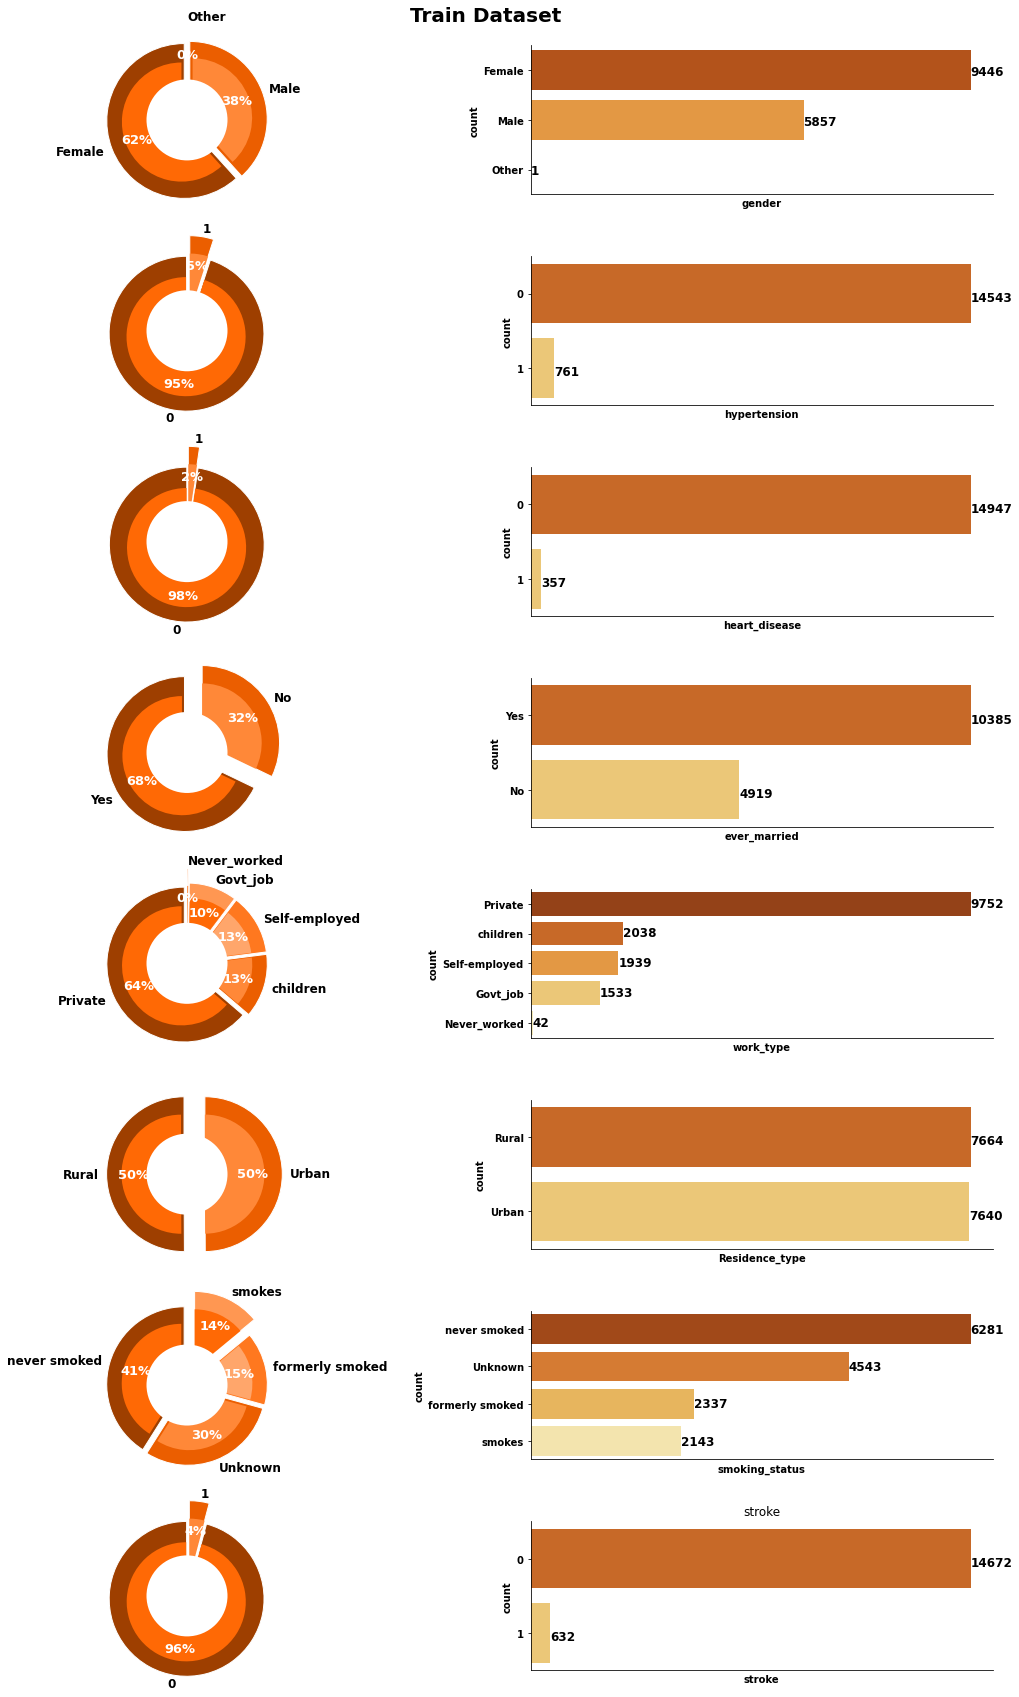

In [11]:
cat_and_target_features = cat_features.copy()
cat_and_target_features.append(config.TARGET)
plot_count(df, cat_and_target_features)


Initial observations:

- There are more females than males (62% vs 38%) in the dataset. There is 1 other in the gender self-identified as other.
- Those who have heart disease are only 2% of the data.
- ~2/3 of the population was married at some point of their life or still married.
- 64% of the population are privately employed.
- Residence type is perfectly balanced (city people vs 'villagers' 50% - %50).
- 30% People ever smoked, 30% is shy about it (unknown), and 41% pretend they never.
- There is 4% of strokes in the dataset where heart disease is only 2%. That is interesting.\*

There is heavy target imbalance


In [12]:
df_test = pd.read_csv(config.TEST_DATA)


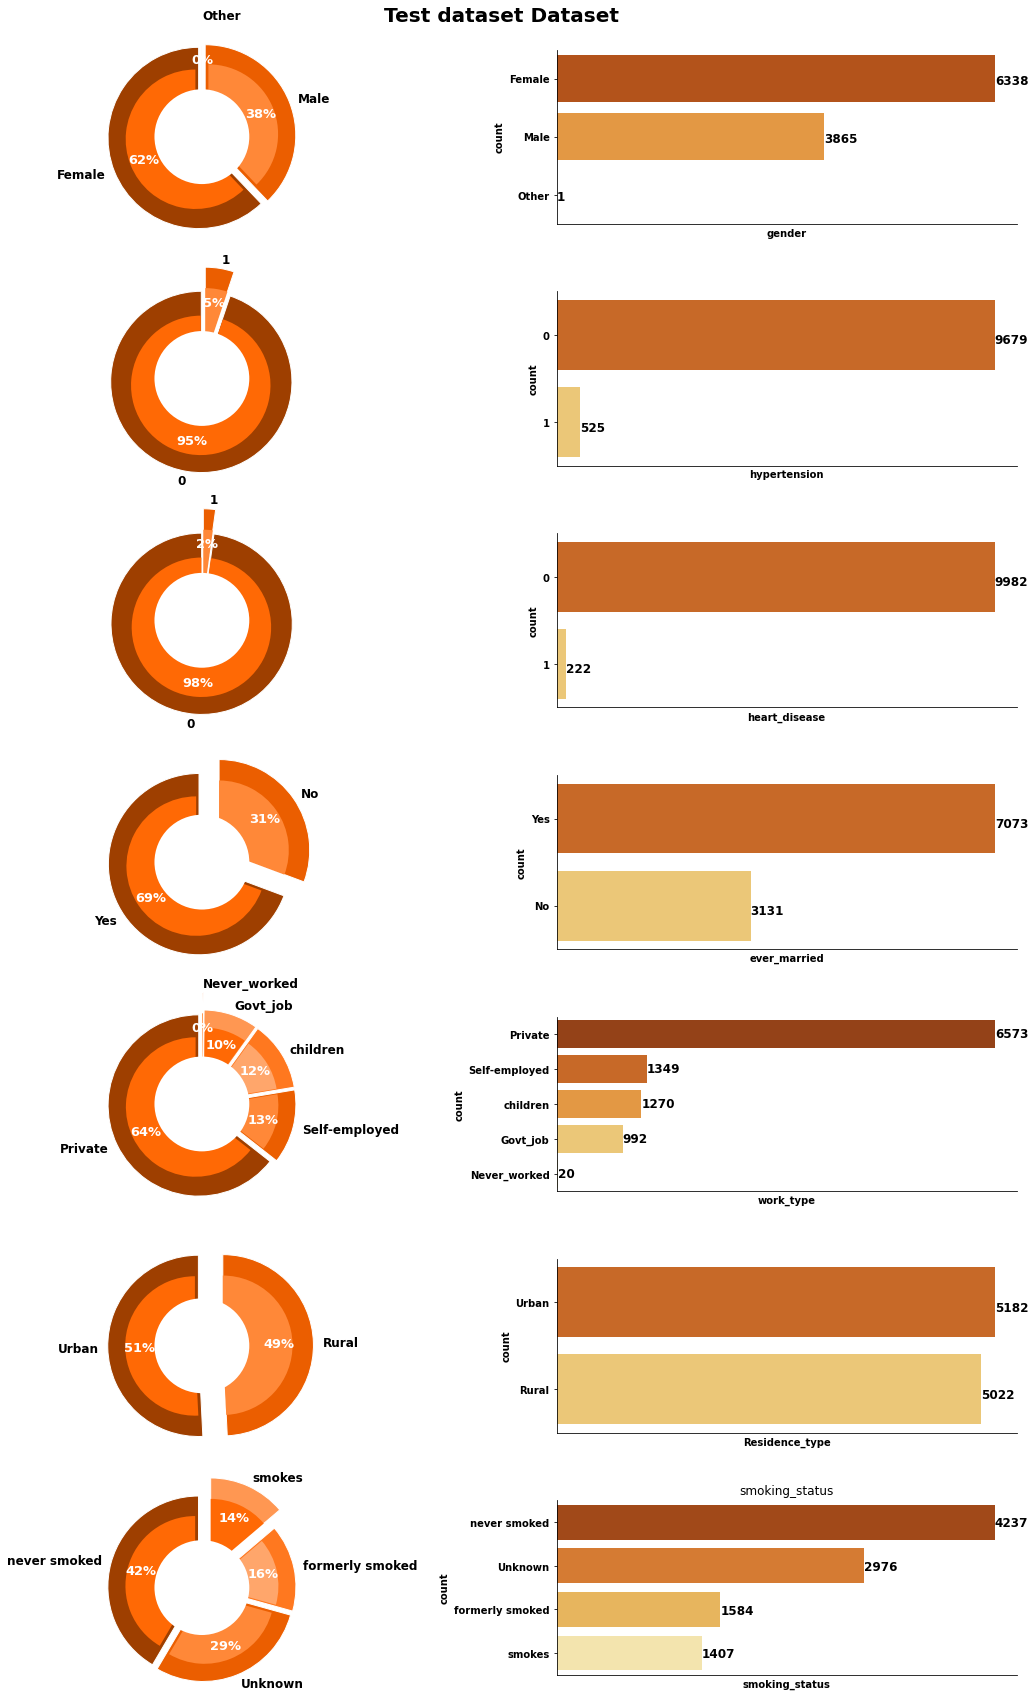

In [13]:
plot_count(df_test, cat_features, title_name="Test dataset")


In [14]:
df["is_train"] = 1
df_test["is_train"] = 0

# Remove id as it doesn't gives analysis value
df.drop(columns="id", inplace=True)
df_test.drop(columns="id", inplace=True)

combined_data = pd.concat(
    [
        df[df.gender.ne("Other")].drop(columns=config.TARGET),
        df_test[df_test.gender.ne("Other")],
    ]
).reset_index(drop=True)

df.drop(columns="is_train", inplace=True)
df_test.drop(columns="is_train", inplace=True)


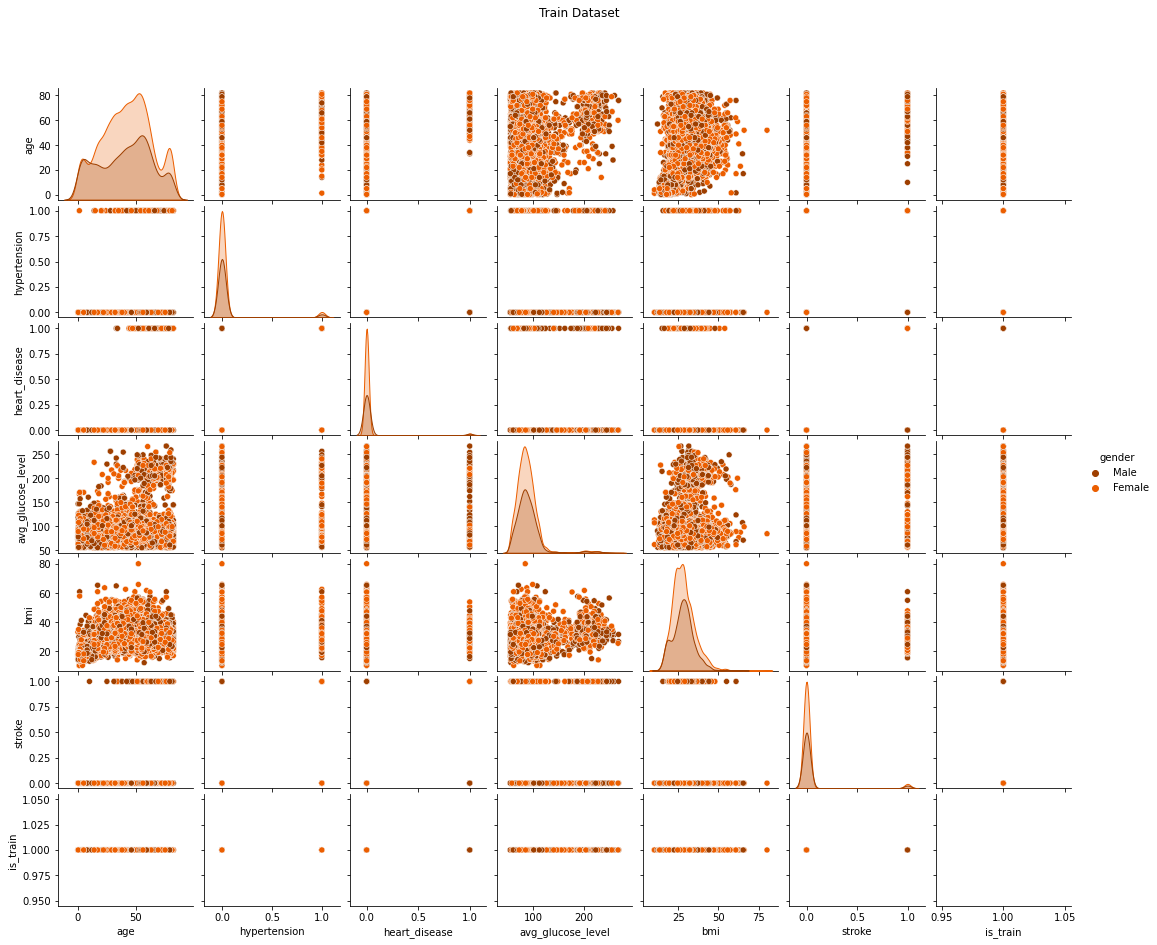

In [15]:
pair_plot(df[df.gender.ne("Other")], title_name="Train Dataset", hue="gender")

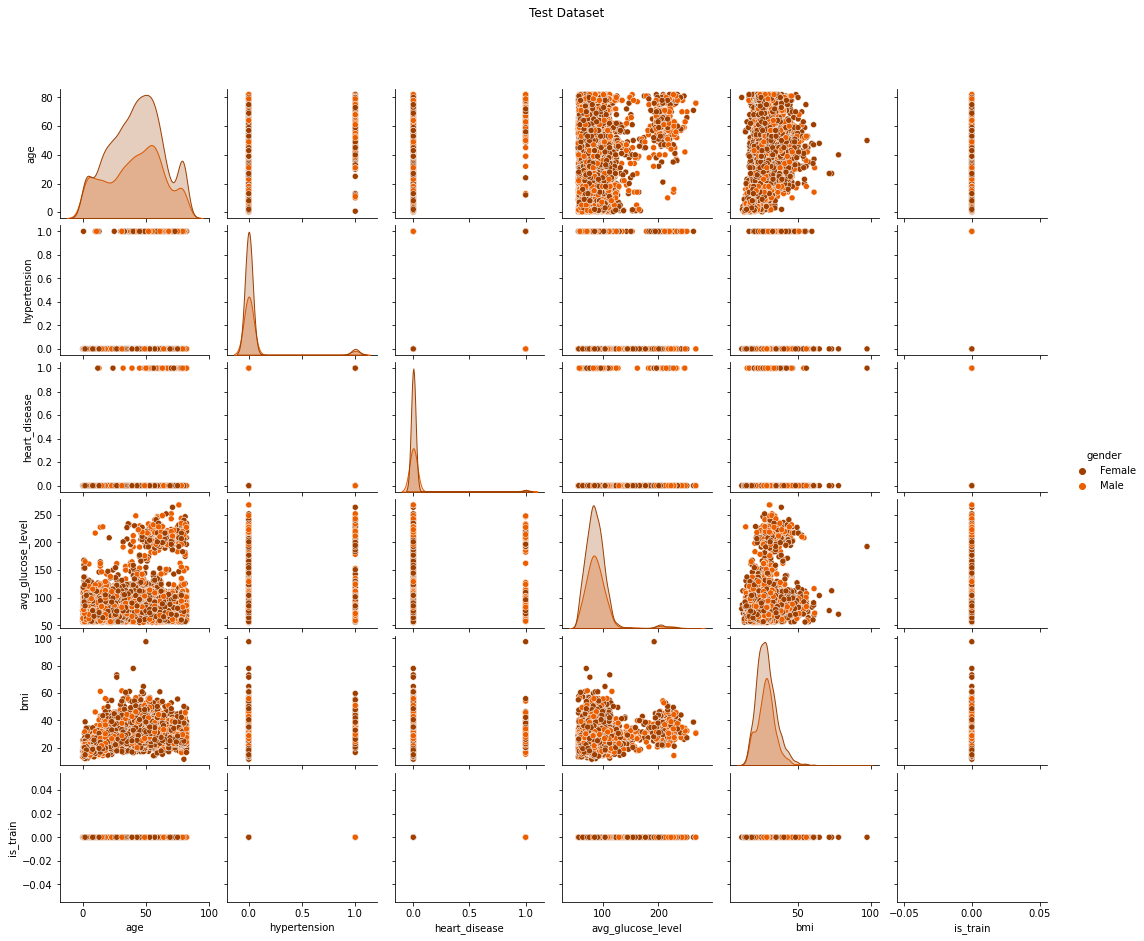

In [16]:
pair_plot(df_test[df_test.gender.ne("Other")], title_name="Test Dataset", hue="gender")

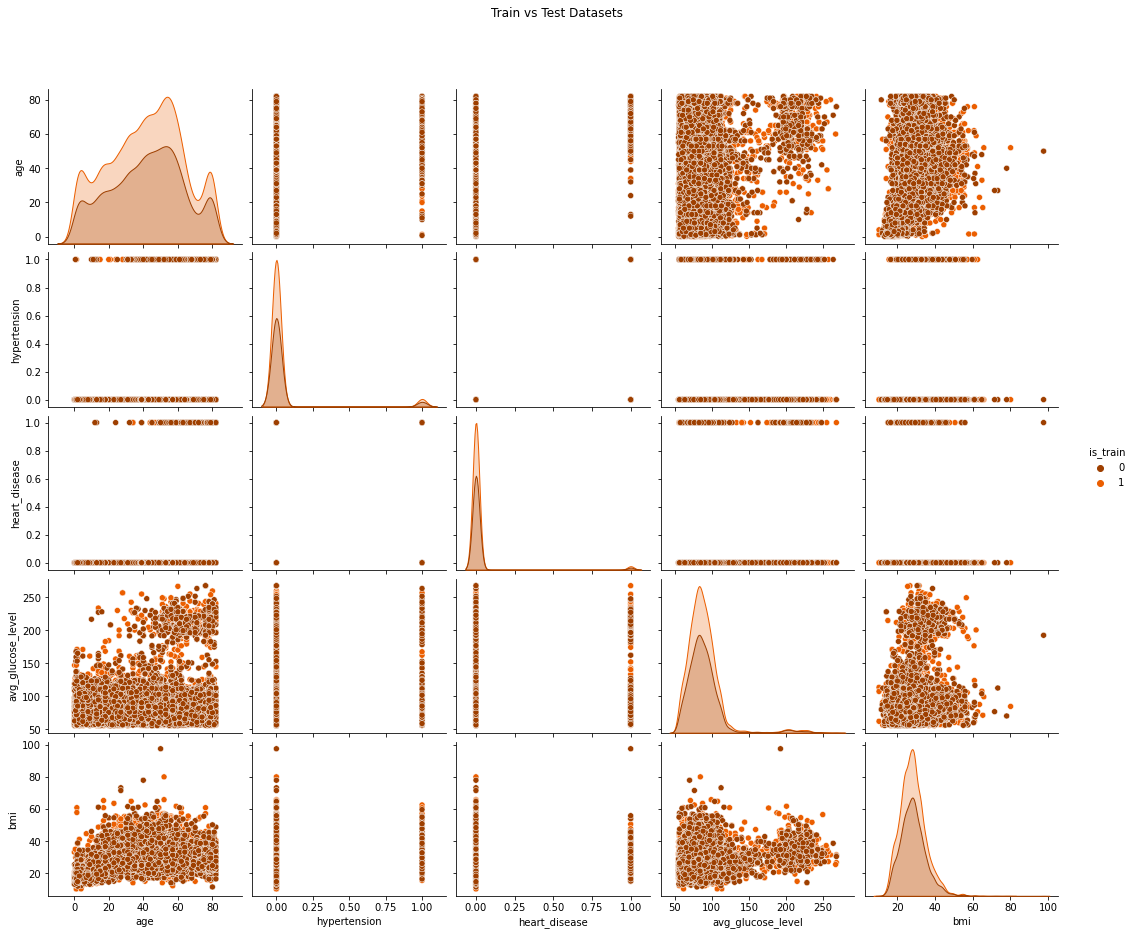

In [17]:
pair_plot(combined_data, title_name="Train vs Test Datasets", hue="is_train")

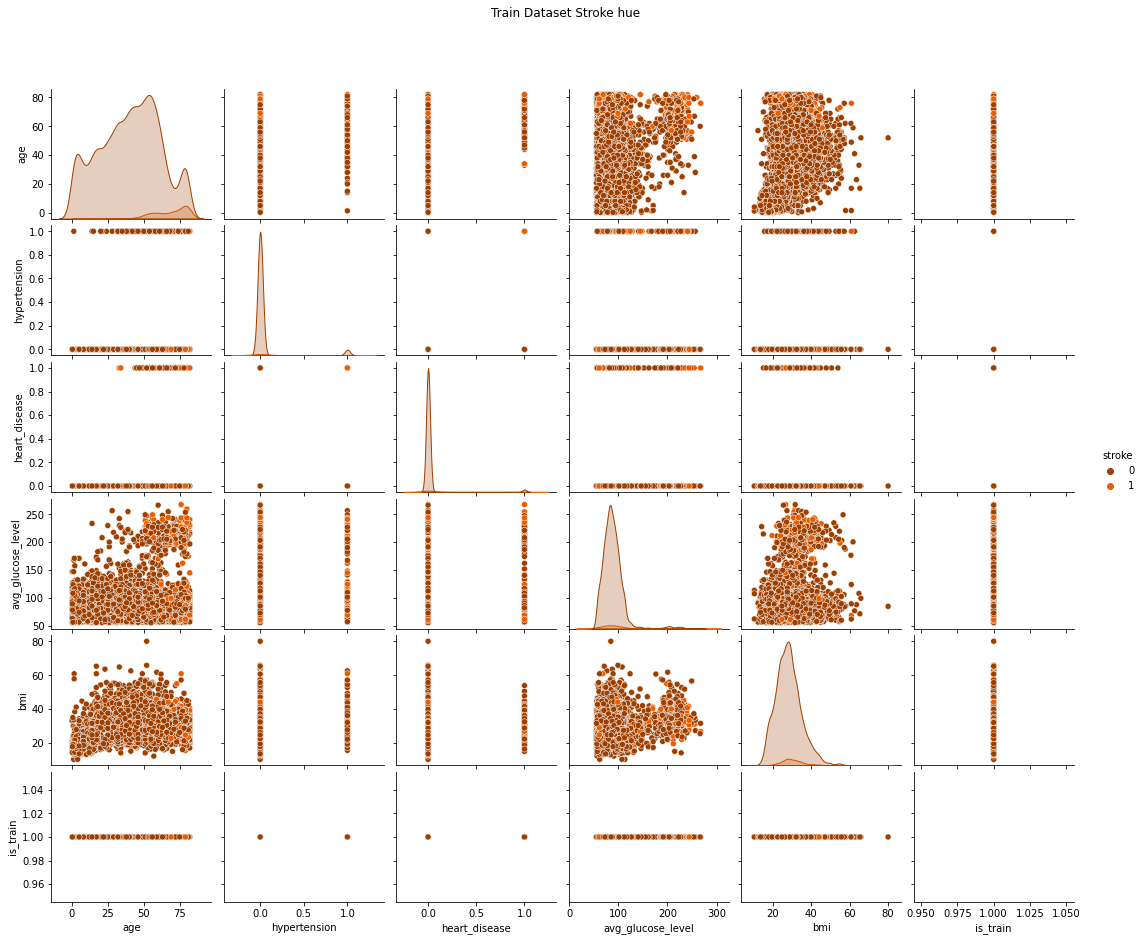

In [18]:
pair_plot(df[df.gender.ne("Other")], title_name="Train Dataset Stroke hue", hue="stroke")

Pairplots notes:

* Stroke becomes a major risk after ~age of 30. Older the person is higher the risk.
* bmi for stroke is between ~20-60 range. Google says Repeated studies estimate that each unit increase in body mass index (BMI) increases the risk of stroke by 5 percent.
* Strokes are more likely with high average glucose level.
* Test dataset follows train dataset distribution almost perfectily.

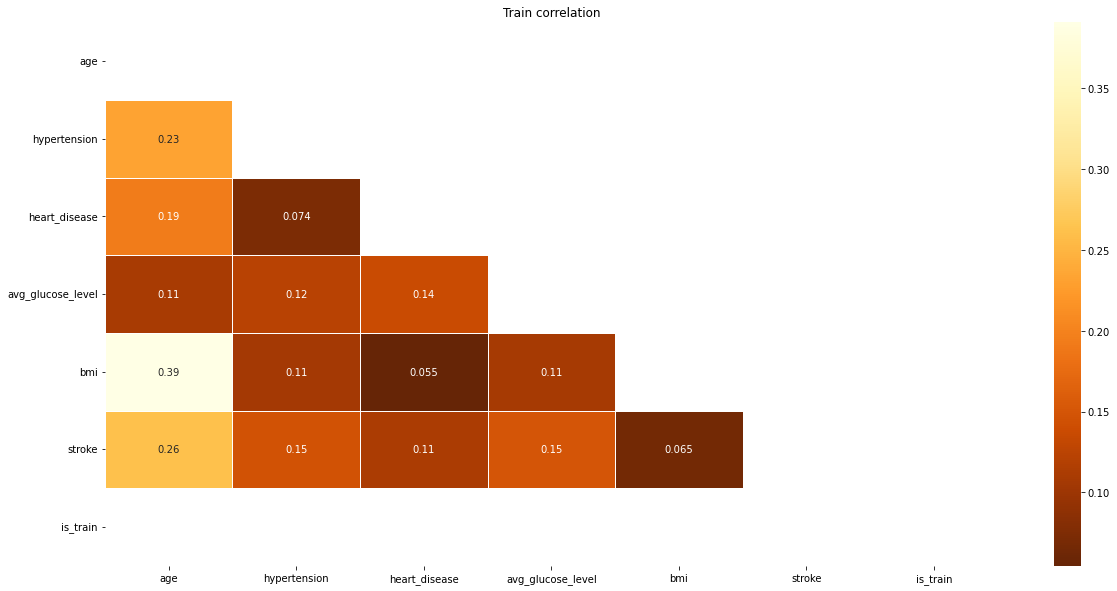

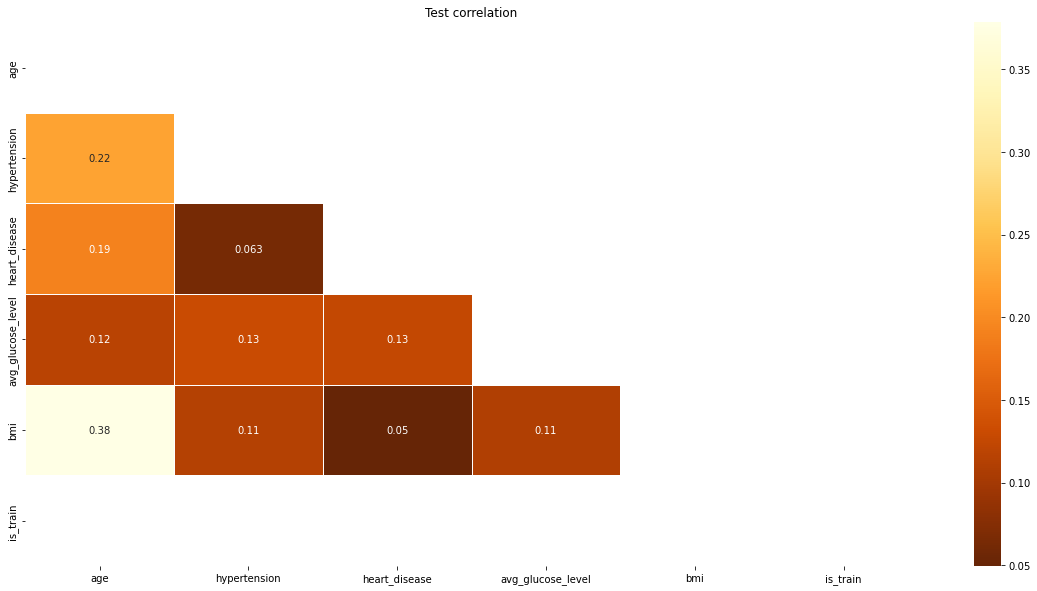

In [19]:
plot_correlation_heatmap(df)
plot_correlation_heatmap(df_test, 'Test correlation')

Correlation plot notes:

* The correlation between numeric features is weak.
* bmi and age somewhat correlate. bmi grows with age?!
* stroke somewhat correlates with BMI and age which seems logical but still the correlation is weak.